In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeRegressor

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import os
os.chdir("D:/files/learning/ML/homework/mid_term")
os.getcwd()

'D:\\files\\learning\\ML\\homework\\mid_term'

In [4]:
def getData():
    data_meteor = pd.read_csv("data.tsv", sep='\t')
    data_resident = pd.read_csv("pop_data.csv")
    return data_meteor, data_resident

In [5]:
data_m, data_r = getData()

In [6]:
class LinRegPoly():
    def __init__(self, M=2):
        self.w = None
        self.M = M
        
    def sse(self, x, y):
        error = 0
        for i in range(x.shape[0]):
            phi = np.array([x[i] ** k for k in range(self.M + 1)])
            error += 0.5 * (y[i] - np.dot(np.transpose(self.w), phi)) ** 2
        return error

    def fit(self, x, y):
        design_mat = np.zeros([x.shape[0], self.M + 1])
        for i in range(design_mat.shape[0]):
            for j in range (design_mat.shape[1]):
                design_mat[i][j] = x[i] ** j
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(design_mat), design_mat)), np.transpose(design_mat)), y)
        return
    
    def predict(self, x_test):
        y_predict = np.zeros([x_test.shape[0], 1])
        for i in range(x_test.shape[0]):
            for k in range(self.w.shape[0]):
                y_predict[i] += self.w[k] * x_test[i] ** k
        return y_predict

In [7]:
def get_coords(data):
    coords={}
    for column in data.columns:
        if column != 'Time':
            coords[column] = np.expand_dims(np.array(data[column]), axis=1)
    return coords

class Meteorite():
    def __init__(self, data):
        self.data = data
        self.time = np.expand_dims(np.array(self.data['Time']), axis=1)
        self.coords = get_coords(self.data)
        self.iter_criterion = 0.01
        
    def make_prediction(self, time_test):
        coords_predict = {}
        for key in self.coords.keys():
            model = LinRegPoly(2)
            model.fit(self.time, self.coords[key])
            coords_predict[key] = model.predict(time_test)
        prediction = np.copy(time_test)
        for key in coords_predict.keys():
            prediction = np.append(prediction, coords_predict[key], axis=1)
        df = pd.DataFrame(prediction)
        df.columns = data_m.columns
        return df
    
    def predict_land_site(self, show=True):
        time_test = np.expand_dims(np.arange(np.max(self.time), 1.2 * np.max(self.time), (np.max(self.time) / 100)), axis=1)
        while True:
            df = self.make_prediction(time_test)
            landed = df[df['Z-Coord'] <= 0]
            not_landed = df[~df.index.isin(landed.index)]
            if len(landed) == 0:
                time_test = np.expand_dims(np.arange(np.max(time_test), 1.2 * np.max(time_test), (np.max(time_test) / 100)), axis=1)
            elif len(not_landed) == 0:
                time_test = np.expand_dims(np.arange(0.8 * np.min(time_test), np.min(time_test), (np.min(time_test) / 100)), axis=1)
            else:
                l_margin = not_landed.iloc[-1]
                r_margin = landed.iloc[0]
                if abs(r_margin['Time'] - l_margin['Time']) < self.iter_criterion:
                    break
                time_test = np.expand_dims(np.arange(l_margin['Time'], r_margin['Time'], (r_margin['Time'] - l_margin['Time']) / 100), axis=1)
        if show:
            print('The predicted landing time is between ' + str(l_margin['Time']) + ' and ' + str(r_margin['Time']))
            print('The X coordinate of the predicted landing location is between ' + str(l_margin['X-Coord']) + ' and ' + str(r_margin['X-Coord']))
            print('The Y coordinate of the predicted landing location is between ' + str(l_margin['Y-Coord']) + ' and ' + str(r_margin['Y-Coord']))
        mean_value = {}
        for column in df.columns:
            if column != 'Z-Coord':
                mean_value[column] = (r_margin[column] + l_margin[column]) / 2
        return mean_value
    
    def drawplot(self):
        time_test = np.expand_dims(np.arange(1300, 1500, 5), axis=1)
        coords_predict = {}
        for key in self.coords.keys():
            model = LinRegPoly(2)
            model.fit(self.time, self.coords[key])
            coords_predict[key] = model.predict(time_test)
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.coords['X-Coord'], self.coords['Y-Coord'], self.coords['Z-Coord'], color='b', label='original track')
        ax.scatter(coords_predict['X-Coord'], coords_predict['Y-Coord'], coords_predict['Z-Coord'], color='r', label='predicted track')
        ax.legend(loc='best')
        plt.show()
        
    def random_predict(self, n=100, frac=0.7):
        samples = []
        for i in range(n):
            rand_data = self.data.sample(frac=frac)
            self.time = np.expand_dims(np.array(rand_data['Time']), axis=1)
            self.coords = get_coords(rand_data)
            samples.append(self.predict_land_site(show=False))
        #These two lines are for the recovery of the changed initial value
        self.time = np.expand_dims(np.array(self.data['Time']), axis=1)
        self.coords = get_coords(self.data)
        return samples
    
    def get_interval(self, n=100, frac=0.7):
        samples = self.random_predict(n, frac)
        coords = np.zeros([len(samples), 2])
        for i in range(len(samples)):
            coords[i][0] = samples[i]['X-Coord']
            coords[i][1] = samples[i]['Y-Coord']
        mean = np.mean(coords, axis=0)
        std = np.std(coords, axis=0)
        interval = 1.64 * std / (len(samples) ** 0.5)
        return [mean - interval, mean + interval]

The predicted landing time is between 1481.185739999993 and 1481.187029999993
The X coordinate of the predicted landing location is between 7049.286414226302 and 7049.29072483477
The Y coordinate of the predicted landing location is between 6591.020226754954 and 6591.0242270805875
{'Time': 1481.1863849999932, 'X-Coord': 7049.288569530536, 'Y-Coord': 6591.02222691777}


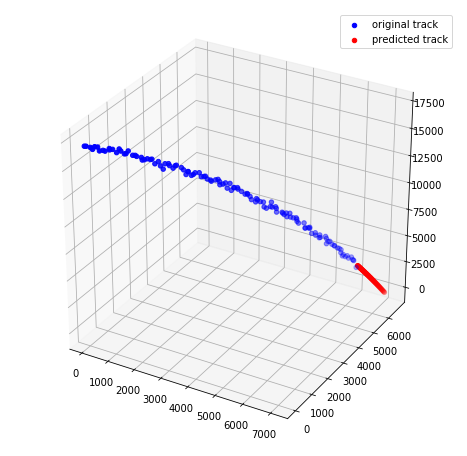

In [8]:
meteor = Meteorite(data_m)
site = meteor.predict_land_site()
print(site)
meteor.drawplot()

---

In [9]:
class Resident():
    def __init__(self, data):
        self.data = data
        self.null = self.data[pd.isnull(self.data['residents'])]
        self.not_null = self.data[pd.notnull(self.data['residents'])]
        
    def remove_null(self):
        model = DecisionTreeRegressor()
        x_train = np.array(self.not_null[['bed', 'bath']])
        y_train = np.expand_dims(np.array(self.not_null['residents']), axis=1)
        model.fit(x_train, y_train)
        x_test = np.array(self.null[['bed', 'bath']])
        y_predict = np.expand_dims(np.around(model.predict(x_test)), axis=1)
        filled = pd.concat([pd.DataFrame(y_predict, index=self.null.index), self.null.iloc[:, 1:]], axis=1)
        filled.columns = self.data.columns
        df = pd.concat([filled, self.not_null])
        self.data = df.sort_index()
        return filled
    
    def predict_impact(self, meteor, show=True):
        if len(self.data[self.data['residents'].isnull()]) != 0:
            self.remove_null()
        interval = meteor.get_interval()
        result = 0
        for i in range(self.data.shape[0]):
            if self.data.iloc[i]['x'] >= interval[0][0] and self.data.iloc[i]['x'] <= interval[1][0]:
                if self.data.iloc[i]['y'] >= interval[0][1] and self.data.iloc[i]['y'] <= interval[1][1]:
                    result += self.data.iloc[i]['residents']
        if show:
            print("The predicted number of affected residents is " + str(int(result)))
        return result
    
    def multiple_predict(self, meteor, predict_times=20, show=True):
        sum_result = 0
        max_result = 0
        for i in range(predict_times):
            result = self.predict_impact(meteor, show=False)
            if result > max_result:
                max_result = result
            sum_result += result
        if show:
            print("After " + str(int(predict_times)) + " times of prediction: ")
            print("The maximum predicted number of affected residents is " + str(int(max_result)))
            print("The average predicted number of affected residents is " + str(sum_result / predict_times)[:5])

In [10]:
res = Resident(data_r)

In [11]:
res.predict_impact(meteor)

The predicted number of affected residents is 0


0

In [12]:
res.multiple_predict(meteor)

After 20 times of prediction: 
The maximum predicted number of affected residents is 5
The average predicted number of affected residents is 1.2
